In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import glob
import pickle
import re
from difflib import SequenceMatcher

### 6. Addition of the genre for each track (Use of LastFM dataset and external website for genre listing)

To find the genre of a song, we will use the LastFM dataset that contains a list a tags for each song.
Since the dataset is from the MillionSongDataset, we will not use all of the available tracks from LastFM but, but only the ones contained in the SecondHandSong dataset.

In [2]:
# Loading the files if they are in the SecondHandSong dataset and create the dataframe
covers_df = pickle.load(open("data/covers.p","rb"))
list_tracks = covers_df.trackID
test_path = "../../lastfm_test"
train_path = "../../lastfm_train"

genre_df = pd.DataFrame()
def create_dataFrame(genre_df):
    for track in list_tracks:
        folder1 = track[2]
        folder2 = track[3]
        folder3 = track[4]
        folder_path = "/" + folder1 + "/" + folder2 + "/" + folder3 + "/"
        track_path = folder_path + track + ".json"
        if glob.glob(train_path + track_path) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(train_path + track_path)), orient="index").transpose())
        elif glob.glob(test_path + folder_path + track) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(test_path + track_path)), orient="index").transpose())
    genre_df = genre_df.reset_index()
    return genre_df

#tracks_with_tags = create_dataFrame(genre_df)
tracks_with_tags = pickle.load(open("data/last_fm_data.p", "rb"))

We now list the unique tags in the resulting dataframe.

In [3]:
def unique_tags_shs():
    tags = list()
    for track in tracks_with_tags.tags:
        if not track is np.nan:
            for tag in track:
                if tag not in tags:
                    tags = tags+tag
    return tags

#tags_shs = unique_tags_shs()
tags_shs = pickle.load(open("data/tags_shs.p", "rb")) 

A lot of tags contains useless information, thus we first proceed to a pre-cleaning.

In [4]:
def filter_zz(tag):
    t = tag.lower()
    return (not "zz" in t or "jazz" in t)
            

def clean_up_tags(tags):
    
    # We first observe a lot of unmeaningful tag with repetitions of characters such as : "----", "ooo", "zzzz" etc
    clean_tags = list(filter(lambda x : not re.match(r'.*o[-o](?![Ff][Ii])', x), tags)) # tags containing "oo" or "o-"
    clean_tags = list(filter(lambda x : not re.match(r'.*-o', x), clean_tags))          # tags containing "-o"
    clean_tags = list(filter(lambda x : not re.match(r'.*--', x), clean_tags))          # tags containing repetitions of "--"
    clean_tags = list(filter(lambda x : filter_zz(x), clean_tags))                      # tags containing repetitions of z but not "jazz"
   
    # Then we note that a lot of tags are "subjective" (Favorite, beautiful...) or don't relate to music genre "Love", "Sex", "Cover"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*fav', x), clean_tags))   # tags containing "fav" like "My favorite song"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*beau', x), clean_tags))  # tags containing "beau" like "Beautiful song"
    clean_tags = list(filter(lambda x : not re.match(r'^\d+\'?s?\Z', x), clean_tags)) # tags starting with a number
    clean_tags = list(filter(lambda x : not re.match(r'^\'\d+\s?', x), clean_tags))   # tags starting with a number
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*lov', x), clean_tags))   # tags containing "Love"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*sex', x), clean_tags))   # tags containing "Sex"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*cover', x), clean_tags)) # tags containing "Cover"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*listen', x), clean_tags))# tags containing "Listen"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*\bhate', x), clean_tags))# tags containing "Hate"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*like', x), clean_tags))  # tags containing "Like"
    
    
    # We also filter all tags with a less than 3 characters.
    clean_tags = list(filter(lambda x : len(x) > 2, clean_tags))
    
    return clean_tags
    
print("Number of tags before cleaning : " + str(len(tags_shs)))
tags_shs = list(np.unique(clean_up_tags(tags_shs)))
print("Number of tags after cleaning : " + str(len(tags_shs)))

Number of tags before cleaning : 416074
Number of tags after cleaning : 66336


In order assign a genre to each song, we will use their different tags and try to match it with a list of genre obtained by webscrapping the http://www.musicgenreslist.com website. For more details on the webscrapping see the notebook Genre Webscrapping.ipynb.

In [5]:
genre_dict = pickle.load(open("data/genres_categories.p", "rb"))
all_genres = pickle.load(open("data/all_genres.p", "rb"))

The all_genres list contains all the genres together, and the genre_dict is a dictionary each "general" genre to its subgenres, e.g. for "Rock" below, we can find Acid Rock, Afro Punk, Alternative Rock, and more.

In [6]:
genre_dict["Rock"][:5]

['Acid Rock',
 'Adult-Oriented Rock',
 'Afro Punk',
 'Adult Alternative',
 'Alternative Rock']

We first proceed to a basic matching : if the tag is contained in a genre, and vice versa, then we have a match.

In [7]:
def tag_in_genre(t, genre):
    g = genre.lower().replace("&", "n")
    match = ""
    if "/" in g :
        g1 = g.split("/")[0]
        g2 = g.split("/")[1]
        if (t in g1) or (g1 in t):
            return genre.split("/")[0]
        elif (t in g2) or (g2 in t):
            match = genre.split("/")[1]
        else: 
            match = ""
    elif (t in g) or (g in t) :
        match = genre
    return match

def generalize_match(match, genres):
    for g in genres.keys():
        if match in genres[g]:
            return g
    return match
    
def first_matching(genres, tags, all_genres):
    tag_to_genre = {}
    no_match = []
    for tag in tags:
        match = ""
        t = tag.lower().replace("'", "").replace("&", "n")
        for genre in genres.keys():
            if match == "":
                match = tag_in_genre(t, genre)
        if match == "":
            for genre in all_genres:
                if match == "":
                    match = tag_in_genre(t, genre)
            if match == "":
                no_match.append(tag)
            else:
                match = generalize_match(match, genres)
        
        tag_to_genre[tag] = match
    return (tag_to_genre, no_match)

In [8]:
(tag_to_genre, no_match) = first_matching(genre_dict, tags_shs, all_genres)

In [9]:
print("Number of tags : {} \
      \nNumber of tags matching a genre : {} \
      \nPercentage of matching = {: .2f} %"\
      .format(len(tag_to_genre), len(tag_to_genre)-len(no_match), 100 - len(no_match)/len(tag_to_genre)*100))

Number of tags : 66336       
Number of tags matching a genre : 13088       
Percentage of matching =  19.73 %


Around 20% of the tags (not all the tags, as we already removed some garbage tags before) correspong to a matching. 

We will now try to assign a genre for each track we have.

In [10]:
def find_match(tags, tag_to_genre):
    if type(tags) == float:
        return tags
    else:
        for tag in tags:
            if tag[0] in tag_to_genre.keys() and tag_to_genre[tag[0]] != "":
                return tag_to_genre[tag[0]]
        return np.nan

In [11]:
tracks_with_tags['genre'] = tracks_with_tags['tags'].map(lambda x : find_match(x, tag_to_genre))
tracks_with_tags.head(20)

,title,tags,artist,genre
track_id,,,,
TRGDMZP128F42BC52B,Stardust,"[[jazz, 100], [trumpet, 75], [swing, 50], [My ...",Louis Armstrong & His Orchestra,Jazz
TRCATYW12903D038FE,Stardust,"[[jazz, 100], [Big Band, 100], [trumpet, 40], ...",Artie Shaw And His Orchestra,Jazz
TRVMZJZ128F4270CE4,Star Dust,"[[jazz standard, 100], [jazz standards, 100], ...",Hoagy Carmichael,Jazz
TROJZTF128F428B546,Yo vengo a ofrecer mi corazón,"[[Ana Belen, 100], [new age, 66], [puro alt, 6...",Ana Belén,New Age
TRYQEDQ128F427917C,Yo Vengo A Ofrecer Mi Corazon,"[[fito paez, 100], [Ro de la Plata, 20], [chai...",Fito Páez,Rock
TRCKNGE128F92DA3F3,Mr. Blue Sky,"[[classic rock, 100], [70s, 77], [rock, 57], [...",Electric Light Orchestra,Rock
TRIOPLY128F423CFF3,Mr Blue Sky,"[[pop, 100], [cover, 100], [happy, 44], [alter...",Lily Allen,Pop
TRWNDEU128F9329BF7,Mr Your On Fire Mr,"[[post-punk, 100], [indie, 50], [2001, 50], [a...",Liars,Alternative
TRYOPHS128F146DEFD,Mr You're on Fire Mr,"[[punk, 100], [covers, 80], [alternative, 80],...",Yeah Yeah Yeahs,Alternative


In [12]:
total_tracks = len(tracks_with_tags)
tracks_with_genre_nb = len(tracks_with_tags.dropna(axis=0, how="any"))
tracks_with_tags_nb = len(tracks_with_tags[['title', 'tags']].dropna(axis=0, how="any"))

print("On {} tracks, {} ({:.2f} %) have tags, and we can assign a genre for {} of them, \
which represent {:.2f} % of the total number of tracks, but {:.2f} % of tags for which we have tags."\
      .format(total_tracks, tracks_with_tags_nb, 100*tracks_with_tags_nb/total_tracks, tracks_with_genre_nb, \
              100*tracks_with_genre_nb/total_tracks, 100*tracks_with_genre_nb/tracks_with_tags_nb))

On 15856 tracks, 12554 (79.18 %) have tags, and we can assign a genre for 11370 of them, which represent 71.71 % of the total number of tracks, but 90.57 % of tags for which we have tags.


In [13]:
pickle.dump(tracks_with_tags, open("data/genres_shs.p", "wb"))

### Visualization

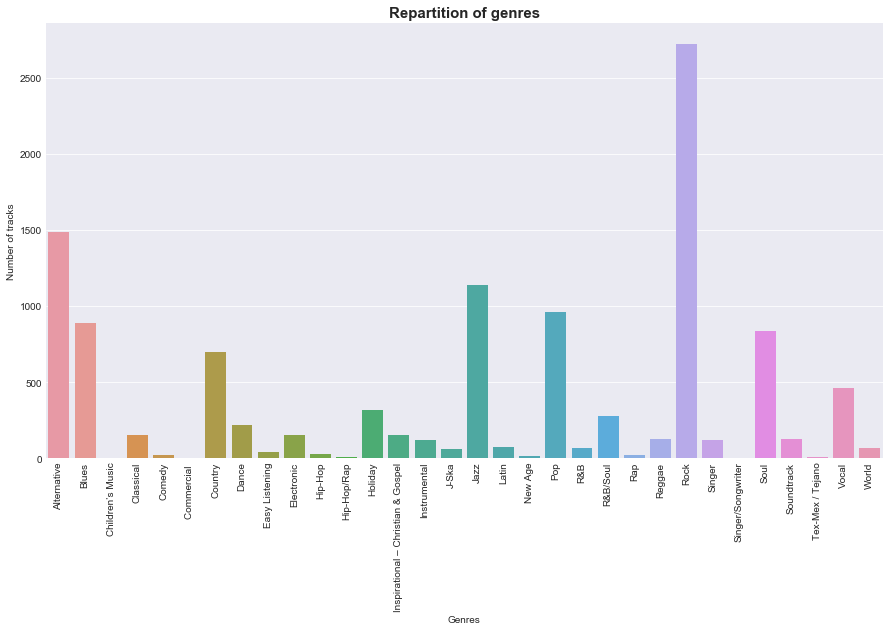

In [59]:
group_by_genre = tracks_with_tags.groupby(tracks_with_tags.genre).count()[['title']]
group_by_genre.columns = ["Number of tracks"]
group_by_genre["Genres"] = group_by_genre.index
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,8))
ax.set_title("Repartition of genres", fontsize=15, fontweight='bold')
sns.barplot(x="Genres", y="Number of tracks" , data=group_by_genre, saturation=0.7, errcolor='.7')
plt.xticks(rotation=90)
plt.show()